## The statistical part
We will use the concept of upscaling to **generate artificial data** to extend the population of quasars measured by the Sloan Digital Sky Survey (SDSS).
The exercise asks us to upscale using two different methods:

- Rejection sampling (worse)
- Inverse transform

Then we want to check (for now visually) that the two cloned distributions (upscaled) are similar to the observed one.<br>
For now we stop here, then we may try to interpret this distribution of quasars in terms of redshift by comparing it with our cosmological model.

In [2]:
#importing packages
import numpy as np
from numpy import random as rnd
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from tqdm.notebook import tqdm

# plot options
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

%config InlineBackend.figure_format='retina'

Redshift ditribution of quasars
 [1.8246 1.8373 1.1985 ... 1.6937 1.2834 1.3542] 
 105783 in total


Text(0.5, 0, 'redshift')

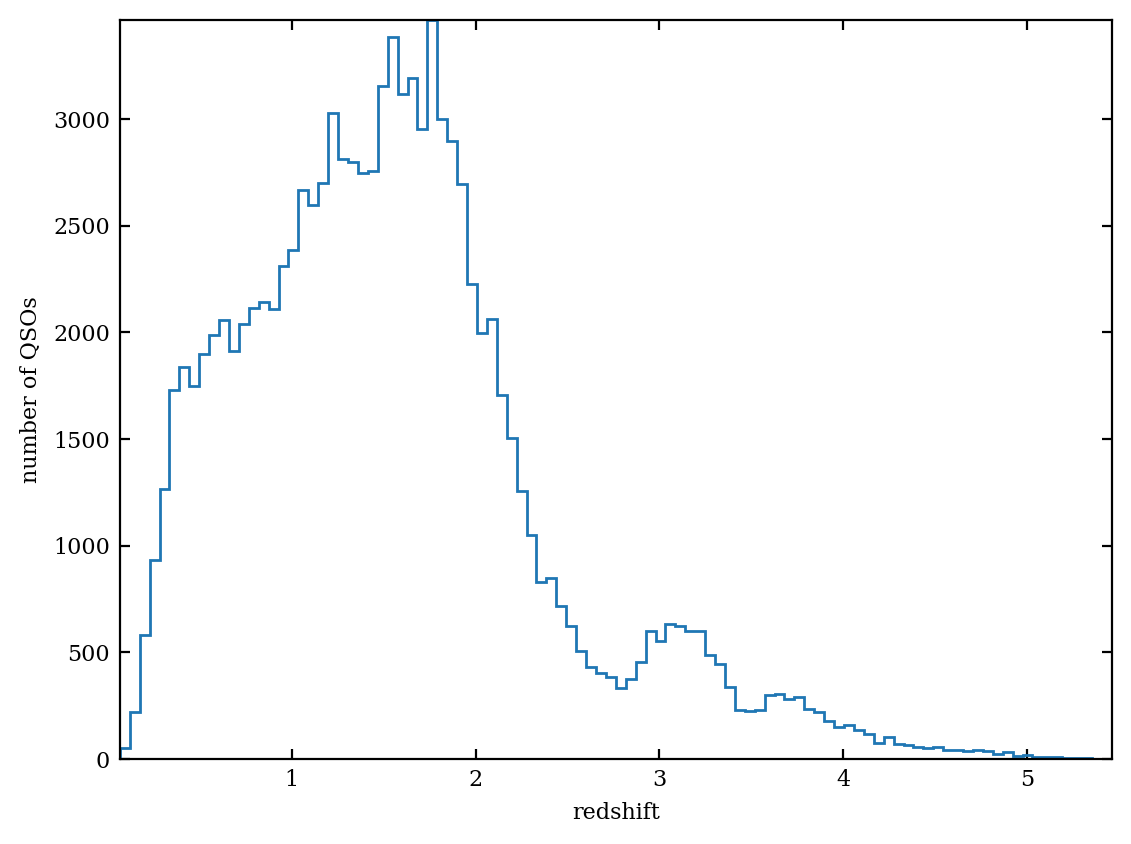

In [48]:
data = np.load('../astroML_data/dr7_quasar.npy');
nb = 100
#i have my data, i need to extract the number of quasars and the redshiftprint(data.dtype) #ID QSO, right asc, declin, redshift, u?, r?, g?s
data = data['redshift']
print(f'Redshift ditribution of quasars\n {data} \n {len(data)} in total')
plt.hist(data, bins = nb, histtype = 'step')
plt.ylabel('number of QSOs')
plt.xlabel('redshift')

### Rejection sampling

The example presented in the lecture had already a known function, in the case of upscaling you don't have this luxury, you have to infer it in some way.
I could take the number of element for each bin and then take this as a function and do rejection sampling

In [39]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from tqdm.notebook import tqdm

# plot options
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

%config InlineBackend.figure_format='retina'

[  51  222  581  932 1268 1729 1836 1750 1897 1986 2058 1915 2038 2113
 2142 2111 2312 2386 2666 2598 2700 3030 2812 2799 2746 2755 3154 3385
 3115 3193 2951 3464 2999 2895 2697 2227 1996 2061 1708 1505 1258 1051
  831  848  716  624  507  432  403  385  333  377  456  602  555  635
  622  599  600  487  448  337  231  225  231  300  307  283  290  237
  221  178  149  160  136  117   74  106   72   66   55   52   56   44
   42   40   42   40   25   35   17   18   10    8   10    4    6    5
    0    2]


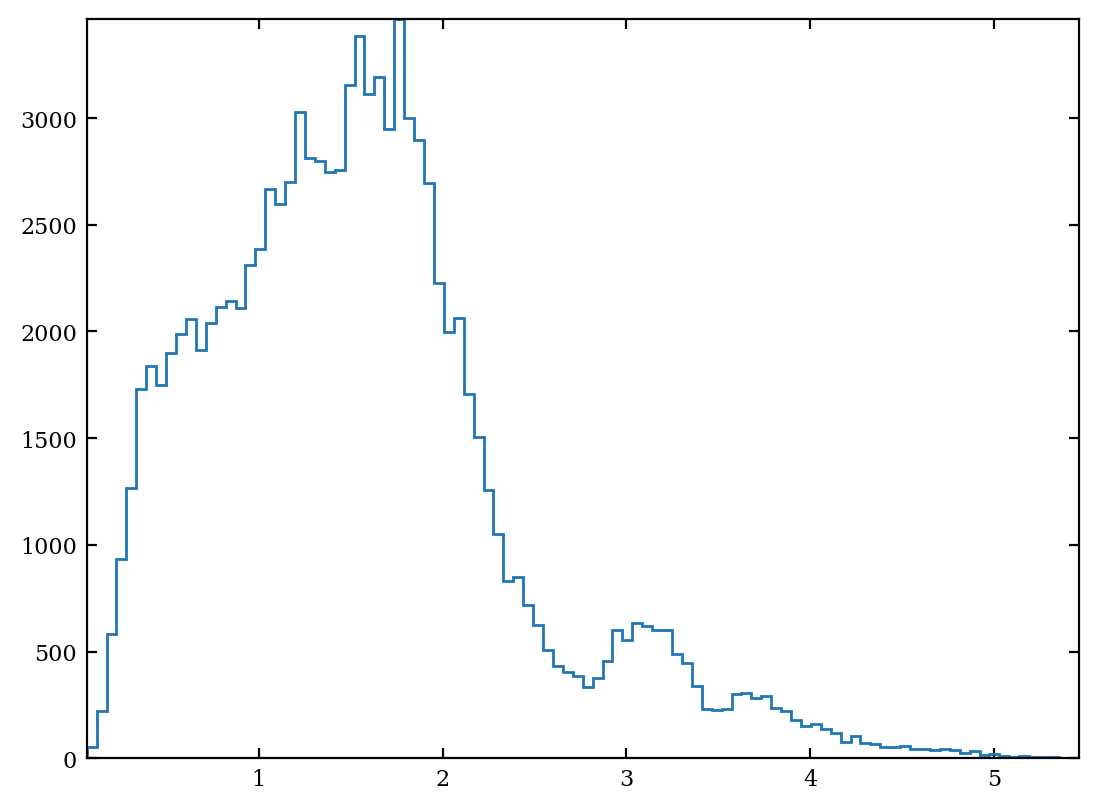

In [5]:
counts, bins, _ = plt.hist(data, bins = nb, histtype = 'step')
print(counts.astype(int))

I start with uniformly distributed points in the whole domain of my discrete function, then for each point i generated i check in which bin it belongs and i accept it only if its y is less or equal the number of counts of that bin (just like if it was a stepfunction)

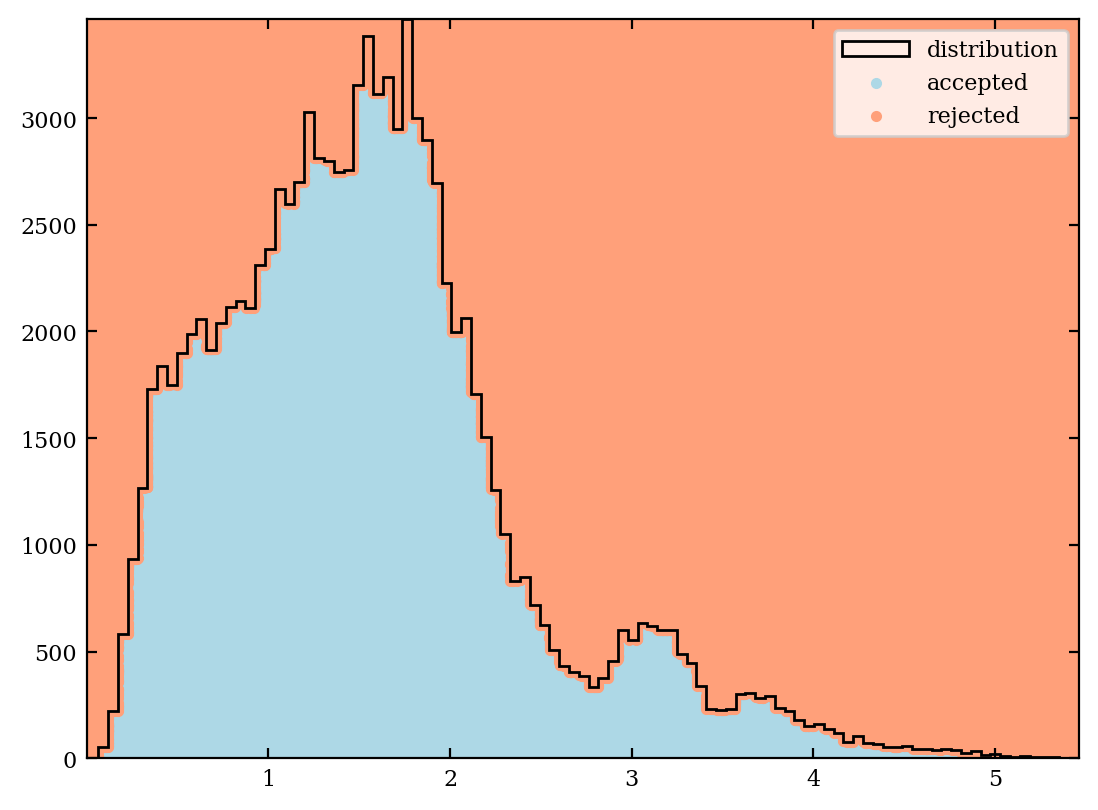

In [33]:
xmax = bins.max()
ymax = counts.max()

N = int(1e6)

x = np.random.uniform(0, xmax, N)
y = np.random.uniform(0, ymax, N)

#implementing the use of masks to do the sorting
#i only want to use the counts for each bin

# Compute the bin indices corresponding to the x values
bin_indices = np.digitize(x, bins) - 1

mask = y <= counts[bin_indices]


plt.hist(data, bins = nb, histtype = 'step', color = 'k', label = 'distribution')
plt.scatter(x[mask], y[mask], marker = ".", color = "lightblue", label = 'accepted')
plt.scatter(x[~mask], y[~mask], marker = ".", color = "lightsalmon", label = 'rejected')

monte_carlo = x[mask] # x mask is the x of the points, i don't care about the y for the histogram

plt.legend(loc='upper right')
plt.show()

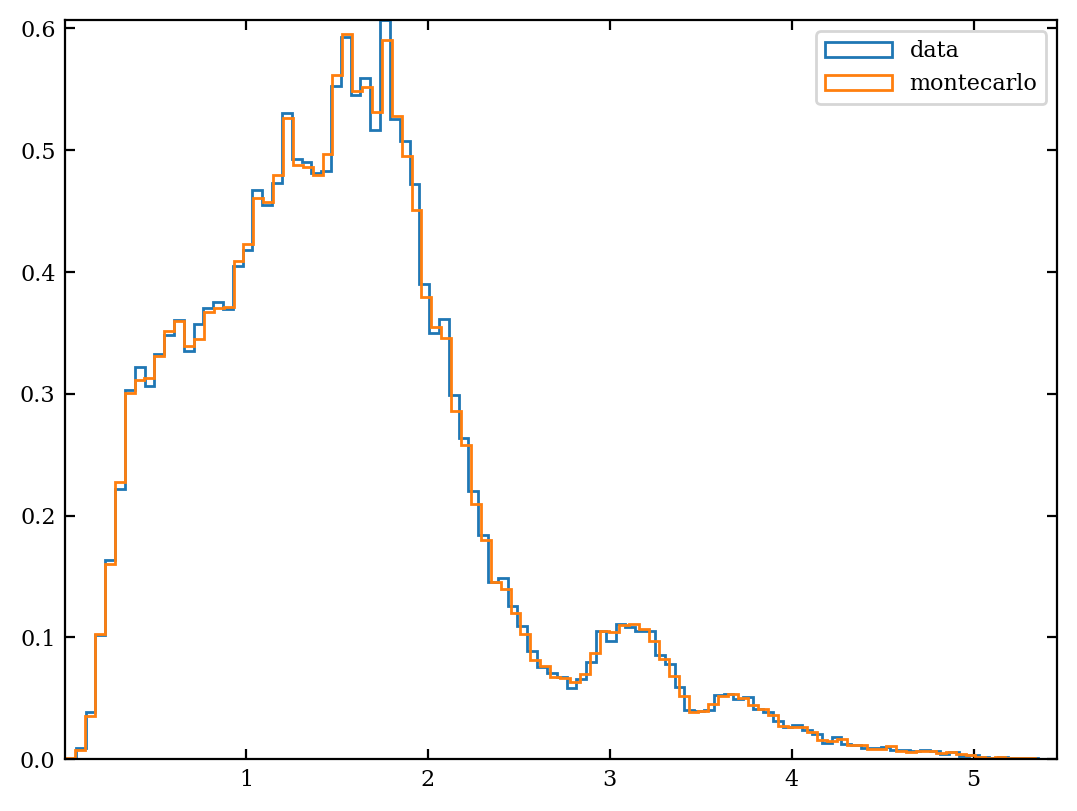

In [39]:
# now  let's show the cloned distribution
plt.hist(data, bins = nb, density = True, histtype = 'step', label = "data")
plt.hist(monte_carlo, bins = nb, density = True, histtype = 'step', color = "C1", label = "montecarlo")

plt.legend()
plt.show()

# Inverse transform sampling

The idea is simple. 

1. Compute the CDF of the desired PDF. The CDF is defined as the integral of the PDF from minus infinity to the variable $x$.
2. Invert the CDF to get the inverse CDF, which maps a uniform random variable between 0 and 1 to the corresponding quantile of the distribution. <br>In fact the cdf $H(x)$ tells you the probability that a point of the distribution is at a certain $x$, it's inverse $h(y) = H^{-1}(y)$ tells you the inverse of that, so the quantile probability. Since any distribution is normalized to 1, the CDF will span from 0 to 1 on $y$
3. Generate a uniform random variable $u$ between 0 and 1, to extract a $y$ from the cdf.
4. Apply the inverse CDF to $u$ to obtain a random variable $x$ that follows the desired PDF.

And then one can just iterate this process to clone the data.<br>
Now the problem is that we have to do all of this in a discrete way, since we don't have the true pdf.

To calculate the integral we can use Riemann, so we sum the area of each bin as we move along x.

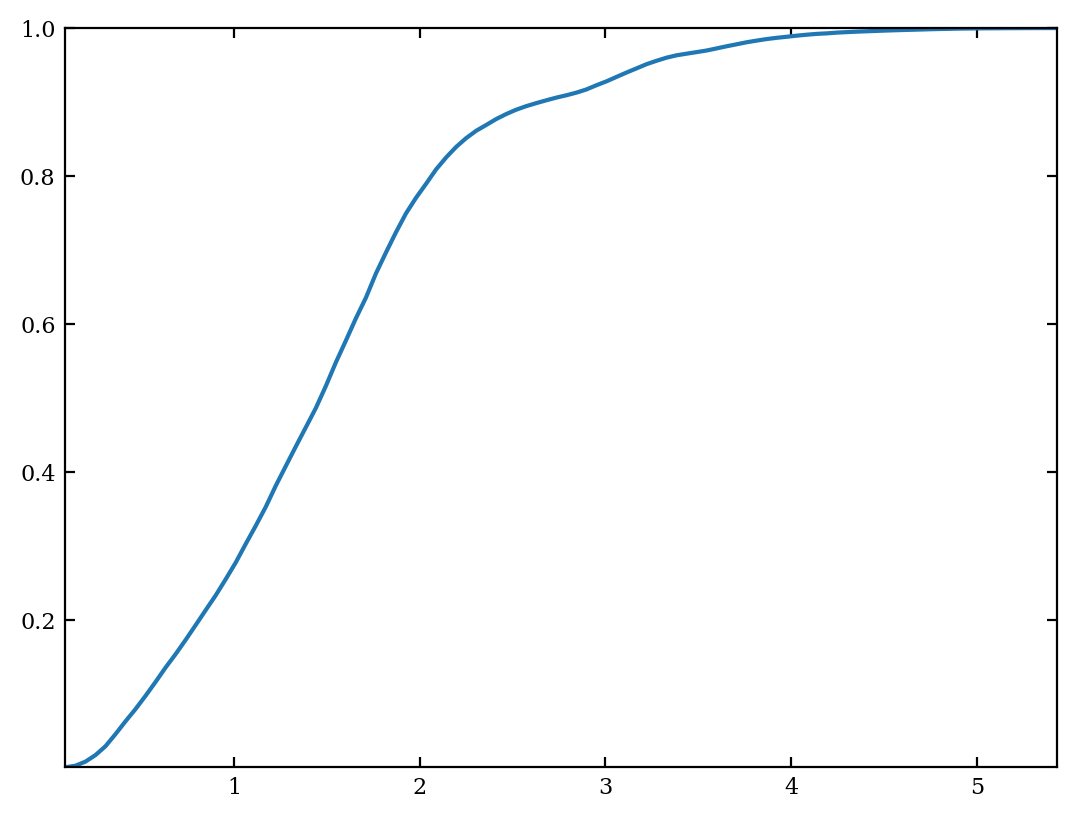

In [40]:
cdf = np.zeros(nb)

cdf = np.cumsum(counts) #integral
cdf /= np.sum(counts)   #normalization
# example of cumsum
# array([[1, 2, 3],[4, 5, 6]])
# array([ 1,  3,  6, 10, 15, 21]) 

mid_bin = (bins[1:] + bins[:-1])/2  #i sum the first point with the second and divide by two

plt.plot(mid_bin, cdf);

I have my CDF now i need to create the inverse.

To obtain the quantile distribution, we use `np.interp` to interpolate the inverse of the CDF at `np.random.rand(1000)` points. `np.random.rand(1000)` generates 1000 random numbers between 0 and 1, which correspond to quantiles of the distribution. In our case we have 100 points of the cdf so we will just interpolate these 100 points.

The `np.interp` function takes these quantiles as the first argument, the CDF as the second argument, and the midpoints of the histogram bins as the third argument. The result of `np.interp` is an array of values from the quantile distribution.

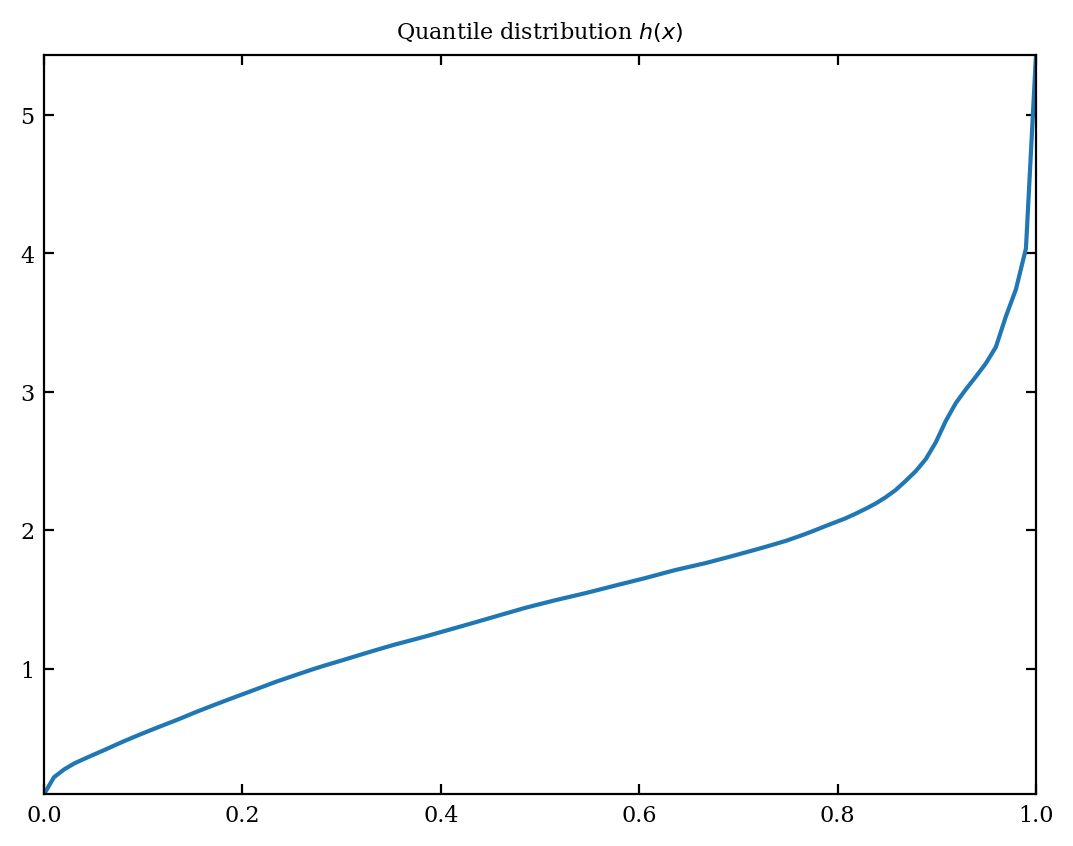

In [43]:
from scipy.interpolate import interp1d

# Invert the CDF to obtain the quantile distribution
qtile = interp1d(cdf, mid_bin) #this sets the interpolation, you need to input the data

plt.plot(np.linspace(0, 1, 100), qtile(np.linspace(cdf.min(), 1, 100)), label='Inverse CDF')
#i use min because if i put 0 it gets angry
plt.title(r"Quantile distribution $h(x)$");

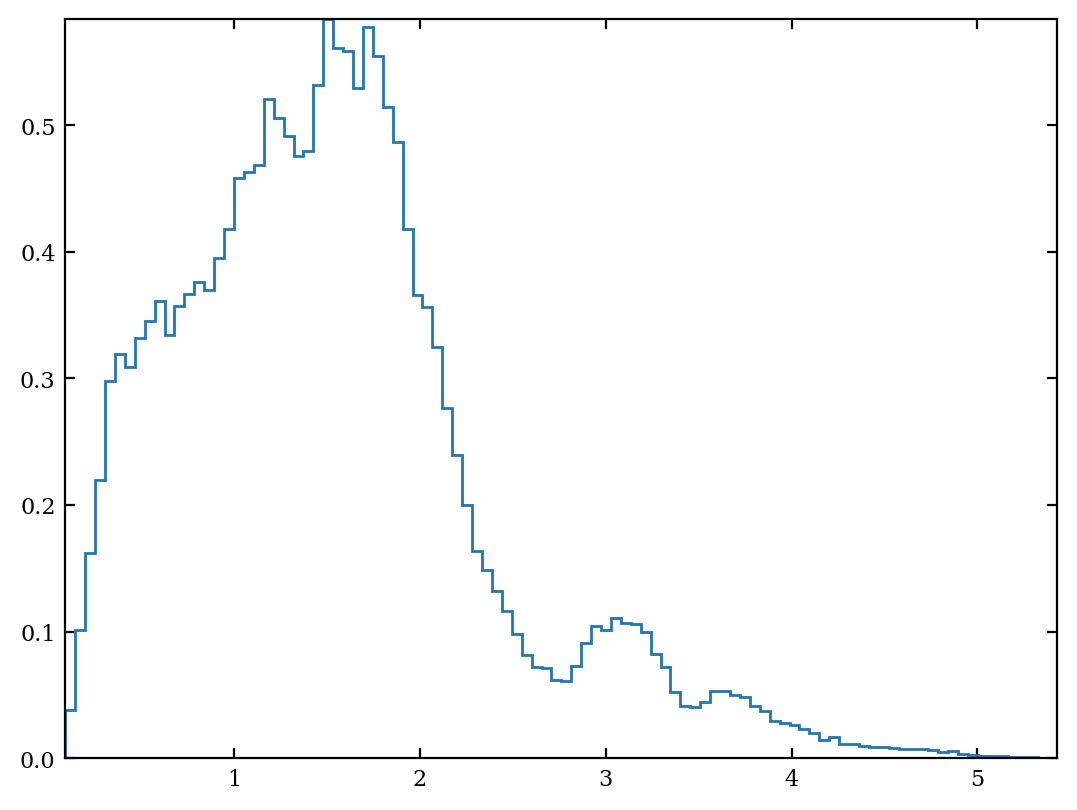

In [44]:
# if i want to upsample i have to clone more than len(data) = 1e5 quasars!
N = int(1e6)

u = np.random.uniform(cdf.min(),1,N) #if you give him 0 it gets mad

x_sample = qtile(u)  #these are the sample images of the quantile dist for the y we generated

plt.hist(x_sample, bins = 100, density=True, histtype="step")
plt.show()

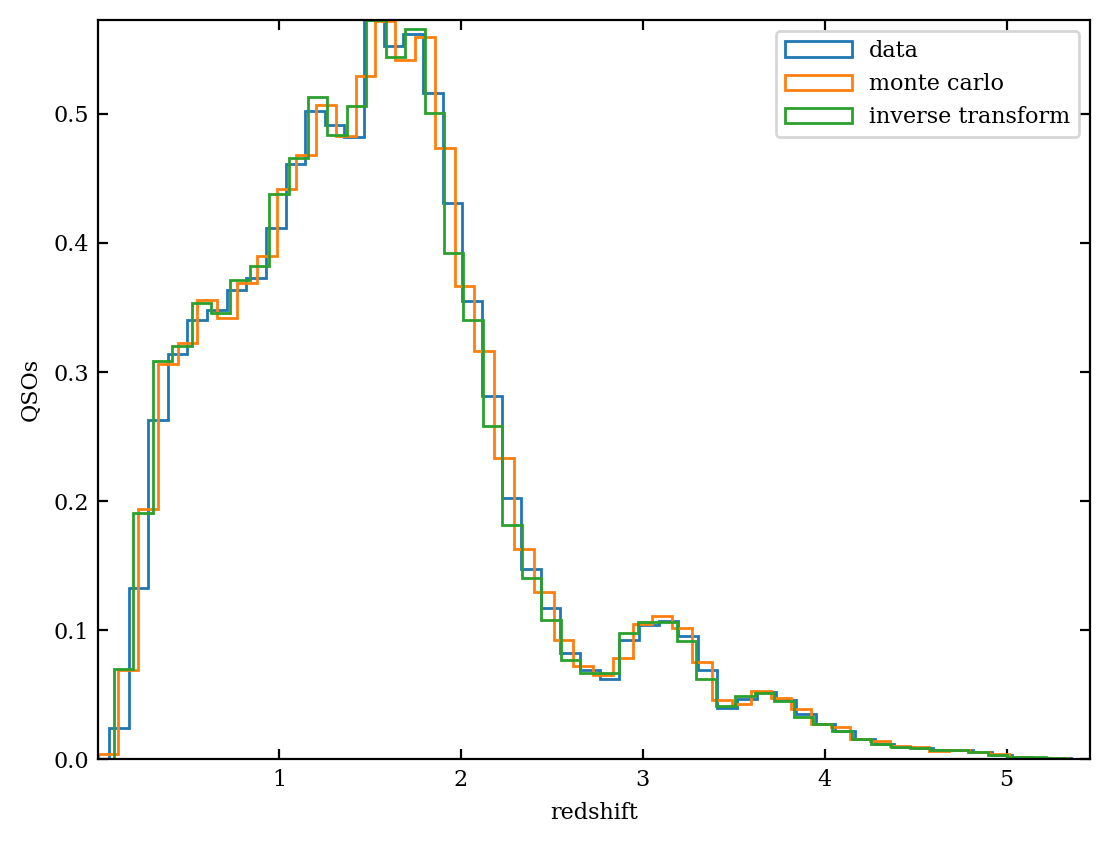

In [49]:
# the three distributions all together
plt.hist(data, bins = 50, density=True, histtype="step", label="data")
plt.hist(monte_carlo, bins = 50, density=True, histtype="step", label="monte carlo")
plt.hist(x_sample, bins = 50, density=True, histtype="step", label="inverse transform")
plt.xlabel('redshift')
plt.ylabel('QSOs')

plt.legend()
plt.show()

As you can see, the inverse transform performes better.

# Cosmology

We have succesfully **upsampled** the data distribution from 1e5 quasars to 1e6 (1 Milion!), we could have done even more! Now we have to remind that this histogram represents the distribution of quasars in the universe.

You can see that most of the quasars is distributed around redshift $z = 2$, so now we wonder if we can match this dsitribution with our current universe model, which follows the flat $\Lambda\ \text{CDM}$ theory.

In [64]:
from astropy.cosmology import Planck15

In [65]:
Planck15

FlatLambdaCDM(name="Planck15", H0=67.74 km / (Mpc s), Om0=0.3075, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)

In [67]:
z = np.linspace(0,5,int(1e5))

In [73]:
y_pred = Planck15.differential_comoving_volume(z).value  #with value i get the numbers

In [86]:
#if i plot now my values aren't normalized, the normalization will be given by 
#the integral of the function, since it's a  distribution, up until the maximum
#redshift of my dataset, in this case 5

from scipy.integrate import quad

#you need to input a function to compute the integral
def commoving(z_):
    return Planck15.differential_comoving_volume(z_).value

norm, abs_err = quad(commoving, 0, 5)

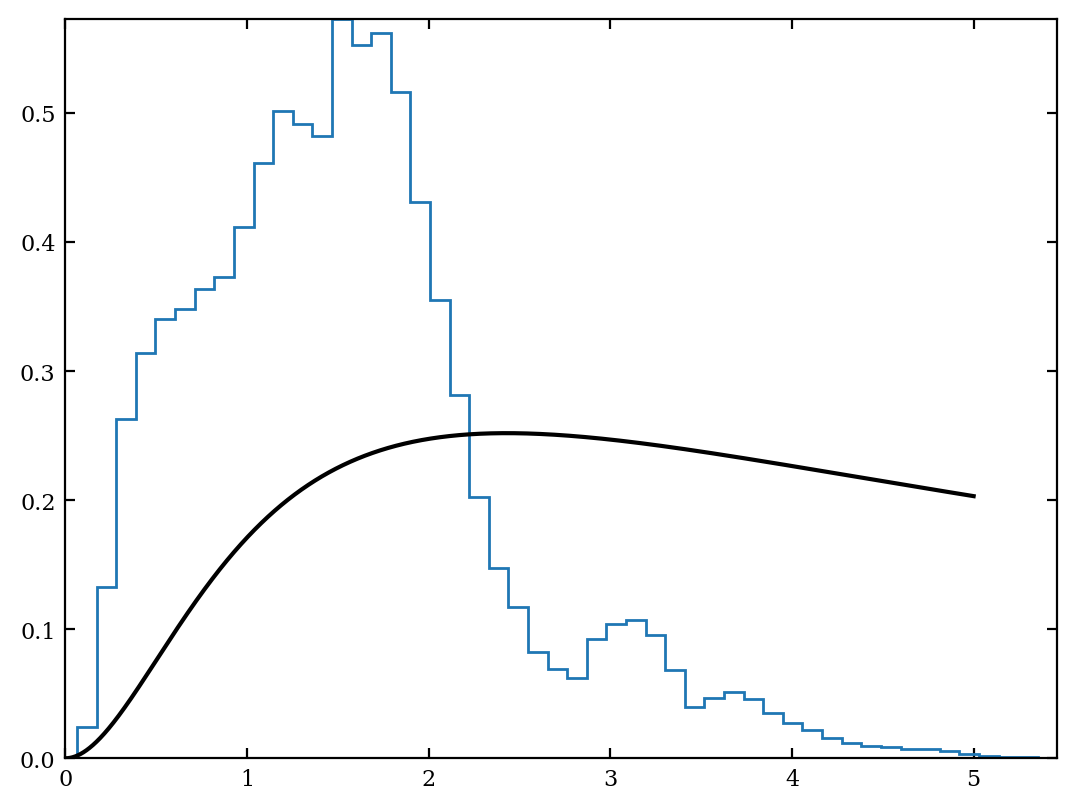

In [88]:
plt.hist(data, bins = 50, density=True, histtype="step", label="data")
plt.plot(z, y_pred/norm, '-k');

Still doesn't match, let's try adding a few values to normalization

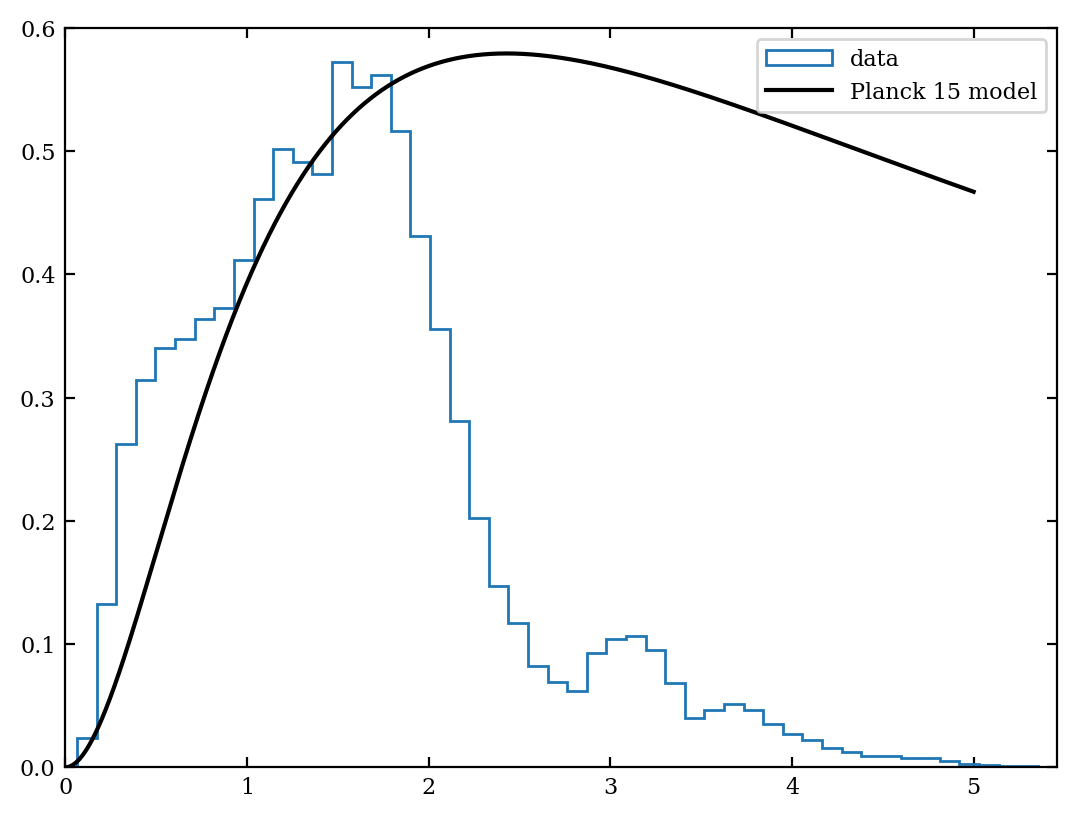

In [108]:
plt.hist(data, bins = 50, density=True, histtype="step", label="data")
plt.plot(z, 2.3*y_pred/norm, '-k', label="Planck 15 model")
plt.ylim(0,.6)
plt.legend();

Apparently they don't match, the reason is because we see only a portion of them, especially at high redshift